# CS 181, Homework 1
## Santiago Giner

## Problem 1
### Problem 1, Subpart 1

In [1]:
# loading data
import numpy as np
import matplotlib.pyplot as plt
from cmath import exp
train_data = np.genfromtxt("data/earth_temperature_sampled_train.csv", delimiter = ',')
year_train = train_data[:, 0] / 1000
temp_train = train_data[:, 1]
test_data = np.genfromtxt("data/earth_temperature_sampled_test.csv", delimiter = ',')
year_test = test_data[:, 0] / 1000
temp_test = test_data[:, 1]

from T1_P1_TestCases import test_p1
from T1_P2_TestCases import test_p2

In [2]:
K_tau = lambda x, xp, tau: np.exp(-(x - xp)**2 / tau)

def f_tau(x, tau, x_arr, y_arr):
    num, denom = 0, 0
    for x_n, y_n in zip(x_arr, y_arr):
            num += K_tau(x_n, x, tau) * y_n
            denom += K_tau(x_n, x, tau)
    return num / denom

def kernel_regressor(x_new, tau, x_train, y_train):
    return np.array([f_tau(x, tau, x_train, y_train) for x in x_new])

In [3]:
test_p1(kernel_regressor)

Passed


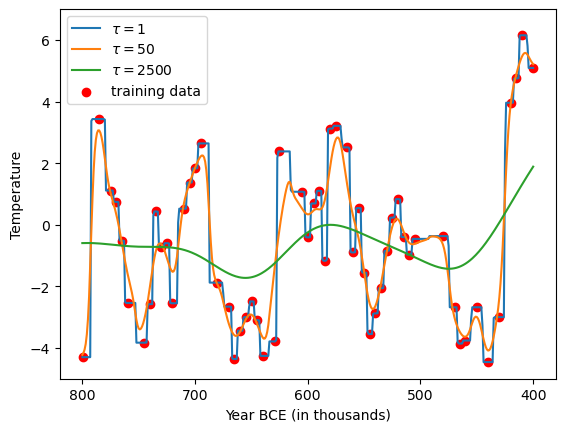

In [4]:
x_array = np.arange(400, 800 + 1, 1)
for tau in [1, 50, 2500]:
    plt.plot(x_array, kernel_regressor(x_array, tau, year_train, temp_train), label = f"$\\tau = {tau}$")
plt.scatter(year_train, temp_train, label = "training data", color = "red")
plt.legend()
plt.xticks(np.arange(400, 800 + 100, 100))
plt.ylabel("Temperature")
plt.xlabel("Year BCE (in thousands)")
plt.ylim([-5,7])

plt.gca().invert_xaxis()
# figure should be in your directory now, with name p1.2.png
plt.savefig("images/p1.2.png", bbox_inches="tight")
plt.show()

### Problem 1, Subpart 4

In [5]:
def model_mse(predictions, true):
    """
    Calculate the MSE for the given model predictions, with respect to the true values
\sum_{n=1}^N K_\tau(x_n, x_m')
    :param predictions: predictions given by the model
    :param true: corresponding true values
    :return: the mean squared error
    """
    # TODO: implement this
    return sum([(p - t)**2 / len(true) for p, t in zip(predictions, true)])

In [6]:
for tau in [1, 50, 2500]:
    print(f"tau = {tau}: loss = {model_mse(kernel_regressor(year_test, tau, year_train, temp_train), temp_test)}")

tau = 1: loss = 1.9472621565209178
tau = 50: loss = 1.8582899169613447
tau = 2500: loss = 8.333886806980791


<hr>

## Problem 2

### Problem 2, Subpart 2

In [7]:
def predict_knn(x_new, k, x_train, y_train):
    """
    Returns predictions for the values in x_test, using KNN predictor with the specified k.

    :param x_new: a numpy array of x_values on which to do prediction. Shape is (n,)
    :param k: number of nearest neighbors to consider
    :param x_train: x coordinates of training dataset
    :param y_train: y coordinates of training dataset

    :return: if x_array = [x_1, x_2, ...], then return [f(x_1), f(x_2), ...]
             where f is the kNN with specified parameters and training set
    """
    tau = 2500
    predictions = np.zeros(len(x_new))
    # Iterate over values for which we want to make a prediction
    for i, x_n in enumerate(x_new):
        # Find distances to each data point in the training set
        distances = np.array([K_tau(x_n, xi, tau) for xi in x_train])
        # Sort distances and get the first k of their y_values
        k_neighbors = y_train[np.argsort(distances)[::-1]][:k]
        predictions[i] = np.mean(k_neighbors, dtype=np.float64)
    return predictions
test_p2(predict_knn)

Passed


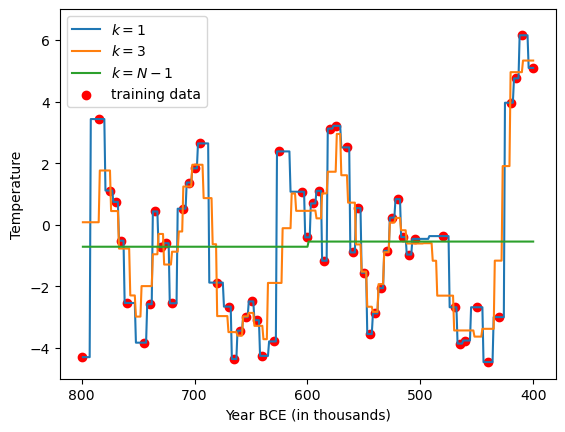

In [8]:
# plot functions
N = year_train.shape[0]
x_array = np.arange(400, 800, 1)
plt.plot(x_array, predict_knn(x_array, 1, year_train, temp_train), label = "$k = 1$")
plt.plot(x_array, predict_knn(x_array, 3, year_train, temp_train), label = "$k = 3$")
plt.plot(x_array, predict_knn(x_array, N - 1, year_train, temp_train), label = "$k = N - 1$")
plt.scatter(year_train, temp_train, label = "training data", color = "red")
plt.ylabel("Temperature")
plt.xlabel("Year BCE (in thousands)")

plt.legend()
plt.xticks(np.arange(400, 900, 100))
plt.ylim([-5,7])

plt.gca().invert_xaxis()
# figure should be in your directory now, with name p2.1.png
plt.savefig("images/p2.1.png", bbox_inches = "tight")
plt.show()

### Problem 2, Subpart 3

In [9]:
# choose your value of k and calculate the loss
for k in [1, 3, 56]:
    print(model_mse(predict_knn(year_test, k, year_train, temp_train), temp_test))

1.7406000000000004
3.8907662222222226
9.528571442602042


## Problem 3

### Problem 3, Subpart 1

In [3]:
## don't change anything here
def f_scale(X, part = "a"):
    if part == "a":
        X = X/181 # 181000
    elif part == "b":
        X = X/4e2 # 4e5
    elif part == "c":
        X = X/1.81 # 1810    
    elif part == "d":
        X = X/.181 # 181
    return X

In [4]:
# TODO: Complete this `make_basis` function according to the above
# specifications. The function should return the array `phi(X)`
def make_basis(X, part='a'):
    """
    Args:
    X: input of years (or any variable you want to turn into the appropriate basis) as
      ndarray with length `N`.
    part: one of `a`, `b`, `c`, `d` depending on the basis function.

    Returns:
    ndarray `phi(X)` of shape `(N,D)`. For each part the shapes of your
    training data `make_basis(years_train)` should be
      (a) 57x10, (b) 57x10, (c) 57x10, (d) 57x50.
    """
  
    phi_X = []
    ### DO NOT CHANGE THIS SECTION 
    ### it is to prevent numerical instability from taking the exponents of
    ### the years, as well as break symmetry when dealing with a Fourier basis.
    X = f_scale(X, part)
    ### end section

    if part == 'a':
        for i, x in enumerate(X):
            # First include the bias term
            phi_X.append([1])
            # Append phi(x) for corresponding part
            [phi_X[i].append(x**j) for j in range(1, 9 + 1)]

    elif part == 'b':
        for i, x in enumerate(X):
            # First include the bias term
            phi_X.append([1])
            # Append phi(x) for corresponding part
            [phi_X[i].append(np.exp(-(x - ((j + 7) / 8))**2 / 5)) for j in range(1, 9 + 1)]

    elif part == 'c':
        for i, x in enumerate(X):
            # First include the bias term
            phi_X.append([1])
            # Append phi(x) for corresponding part
            [phi_X[i].append(np.cos(x / j)) for j in range(1, 9 + 1)]

    elif part == 'd':
        for i, x in enumerate(X):
            # First include the bias term
            phi_X.append([1])
            # Append phi(x) for corresponding part
            [phi_X[i].append(np.cos(x / j)) for j in range(1, 49 + 1)]
    
    # print(phi_X)
    return np.array(phi_X)

In [8]:
make_basis(np.array([181, 281]), part="a")

array([[ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.55248619,  2.41021336,  3.74182296,  5.80912846,
         9.01859169, 14.00123904, 21.73673022, 33.74597343, 52.39015765]])

In [12]:
# Find the regression weights using the Moore-Penrose pseudoinverse.
def find_weights(X, y):
    w_star = np.dot(np.linalg.pinv(np.dot(X.T, X)), np.dot(X.T, y))
    return w_star

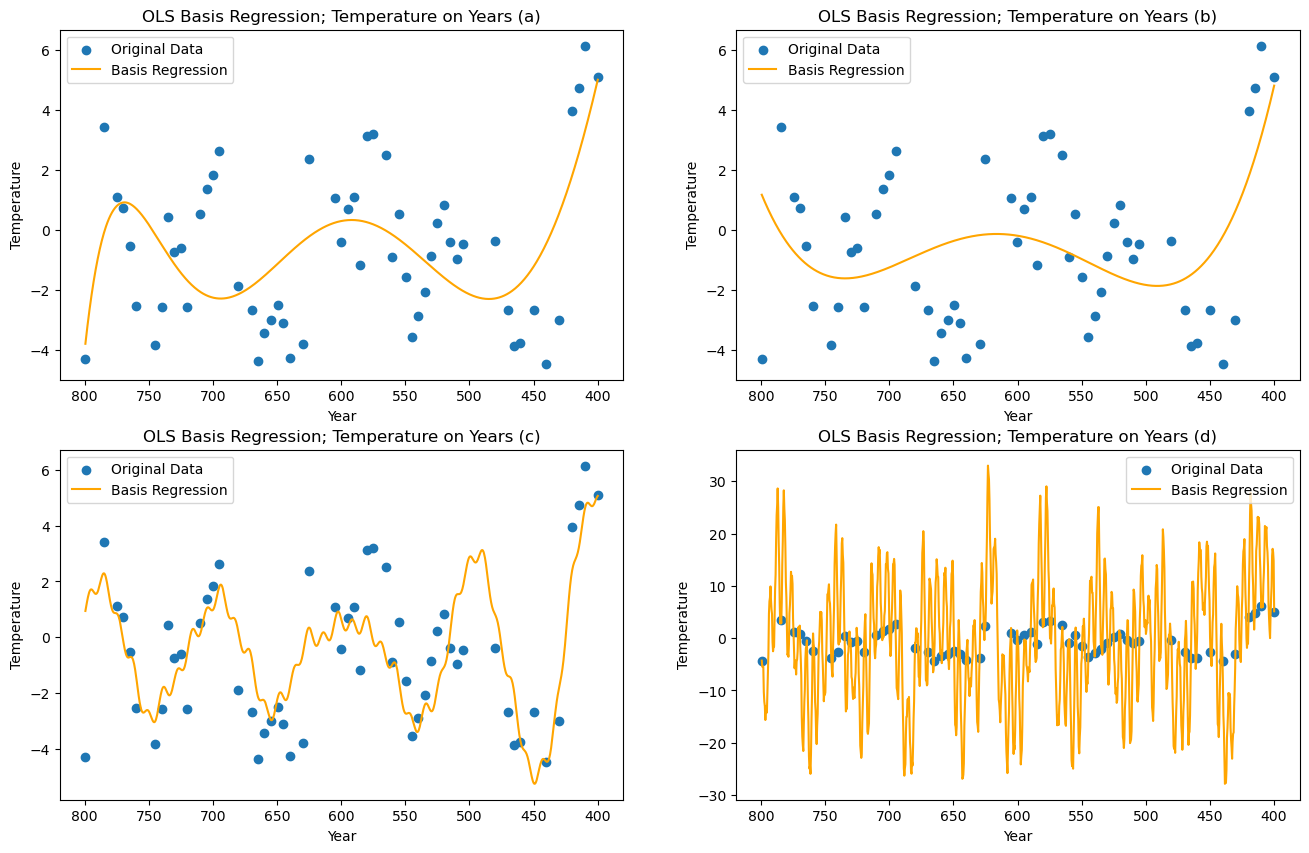

In [13]:
_, ax = plt.subplots(2,2, figsize = (16,10))

for i, part in enumerate(['a', 'b', 'c' ,'d']):
    # Plotting the original data
    ax[i//2, i%2].scatter(year_train, temp_train, label = "Original Data")
    ax[i//2, i%2].set_xlabel("Year")
    ax[i//2, i%2].set_ylabel("Temperature")
    ax[i//2, i%2].set_title(f"OLS Basis Regression; Temperature on Years ({part})")
    ax[i//2, i%2].invert_xaxis()
    
    xs = np.linspace(year_train.min(), year_train.max(), 1000)

    # TODO: plot your functions for the specified xs
    # Find w_star that minimizes MSE
    phi_X = make_basis(year_train, part=part)
    w_star = find_weights(phi_X, temp_train)
    
    # Apply found weights to the test data
    y_pred = np.dot(make_basis(xs, part=part), w_star)
    ax[i//2, i%2].plot(xs, y_pred, color = 'orange', label = "Basis Regression")


    ax[i//2, i%2].legend()

plt.savefig("images/p3.1.png")

### Problem 3, Subpart 2

In [14]:
def mean_squared_error(X, y, w):
    # TODO: Given a linear regression model with parameter w, compute and return the
    # mean squared error.
    N = len(y)
    prediction = np.dot(X, w)
    return np.dot(y - prediction, y - prediction) / N

def negative_log_likelihood(X, y, w, sigma):
    # TODO: Given a probabilistic linear regression model y = w^T x + e, where
    # e is N(0, sigma), return the negative log likelihood of the data X,y.
    N = len(y)
    mse = mean_squared_error(X, y, w)
    return N * np.log(sigma) + N * mse / (2 * sigma**2)

In [15]:
for part in ['a', 'b', 'c', 'd']:
    # TODO: compute the MSE and Likelihood and print the results
    phi_X_train = make_basis(year_train, part=part)
    w_star = find_weights(phi_X_train, temp_train)
    train_mse = mean_squared_error(phi_X_train, temp_train, w_star)
    
    phi_X_test = make_basis(year_test, part=part)
    test_mse = mean_squared_error(phi_X_test, temp_test, w_star)
    print(f"\nPart ({part});\n\n Train MSE: {train_mse:.2f}; Test MSE: {test_mse:.2f}\n")

    # TODO: compute the likelihood. 
    sigma_mle_train = np.sqrt(train_mse)
    train_log_nll = negative_log_likelihood(phi_X_train, temp_train, w_star, sigma_mle_train)
    sigma_mle_test = np.sqrt(test_mse)
    test_log_nll = negative_log_likelihood(phi_X_test, temp_test, w_star, sigma_mle_test)
    print(f" Train Negative Log-Likelihood: {train_log_nll:.3f}; Test Negative Log-Likelihood: {test_log_nll:.3f}")


Part (a);

 Train MSE: 4.83; Test MSE: 7.96

 Train Negative Log-Likelihood: 73.389; Test Negative Log-Likelihood: 38.429

Part (b);

 Train MSE: 5.53; Test MSE: 8.71

 Train Negative Log-Likelihood: 77.241; Test Negative Log-Likelihood: 39.553

Part (c);

 Train MSE: 2.88; Test MSE: 5.97

 Train Negative Log-Likelihood: 58.638; Test Negative Log-Likelihood: 34.828

Part (d);

 Train MSE: 0.64; Test MSE: 58.91

 Train Negative Log-Likelihood: 15.924; Test Negative Log-Likelihood: 63.450
